In [1]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import copy
import tqdm

In [49]:
graph_data = torch.load("/datavol/training_data/testset/ttbar_uncorr_pu200_dumpv5_acorn2.0.0_module_map_minmax_event000000205.pyg", map_location="cpu", weights_only=False)
graph_data

Data(hit_lengthDir1_1=[303766], hit_count_2=[303766], hit_phi_angle_1=[303766], hit_glob_eta_1=[303766], hit_cluster_z_1=[303766], hit_cluster_r_1=[303766], hit_cluster_z_2=[303766], hit_id=[303766], hit_phi=[303766], hit_module_id=[303766], hit_region=[303766], hit_localDir1_2=[303766], hit_localDir2_2=[303766], hit_norm_x_1=[303766], hit_glob_phi_1=[303766], hit_cluster_eta_1=[303766], hit_norm_z_1=[303766], hit_y=[303766], hit_glob_eta_2=[303766], hit_eta_angle_1=[303766], hit_loc_eta_2=[303766], hit_cluster_x_1=[303766], hit_cluster_r_2=[303766], hit_z=[303766], hit_localDir0_1=[303766], hit_cluster_eta_2=[303766], hit_eta=[303766], hit_loc_phi_1=[303766], hit_r=[303766], hit_cluster_y_2=[303766], hit_lengthDir2_1=[303766], hit_norm_x_2=[303766], hit_glob_phi_2=[303766], hit_phi_angle_2=[303766], hit_norm_y_2=[303766], hit_norm_z_2=[303766], hit_lengthDir0_1=[303766], hit_count_1=[303766], hit_localDir2_1=[303766], hit_loc_eta_1=[303766], hit_norm_y_1=[303766], hit_eta_angle_2=[303

In [50]:
graph_data.is_pixel = graph_data.hit_r < 375
graph_data.edge_index_pixel = graph_data.edge_index[:, graph_data.is_pixel[graph_data.edge_index[0]] & graph_data.is_pixel[graph_data.edge_index[1]] ]
graph_data.track_edges_pixel = graph_data.track_edges[:, graph_data.is_pixel[graph_data.track_edges[0]] & graph_data.is_pixel[graph_data.track_edges[1]] ]

In [51]:
graph_data.edge_index_pixel.shape[1], graph_data.track_edges_pixel.shape[1]

(794072, 98816)

In [52]:
import sys
import glob

In [53]:
sys.path.append("build/")

In [54]:
from graph_pruning import filterEdges

In [55]:
node_weights = [ 1 if r < 370 else 2 for r in graph_data.hit_r ]

In [56]:
newSrc, newDst = filterEdges(graph_data.edge_index[0].numpy().tolist(),
                             graph_data.edge_index[1].numpy().tolist(),
                             node_weights, 7)
1 - (len(newSrc) / len(graph_data.edge_index[0])), len(graph_data.edge_index[0]) - len(newSrc)

(0.05473734445463263, 56890)

In [57]:
def cantor(a, b): 
    print(a.dtype, b.dtype)
    return b + (a + b)*(a + b + 1)//2

In [58]:
cantor_before = cantor(graph_data.edge_index[0].numpy(), graph_data.edge_index[1].numpy())
cantor_after = cantor(np.array(newSrc), np.array(newDst))
len(cantor_before), len(cantor_after)

int64 int64
int64 int64


(1039327, 982437)

In [69]:
assert all(np.isin(cantor_after, cantor_before))
pruned_edge_mask = ~np.isin(cantor_before, cantor_after)
assert len(pruned_edge_mask) == len(cantor_before)

In [73]:
def draw_edges(data, ax, edges, xaxis="hit_z", yaxis="hit_r", **kwargs):
    from matplotlib.collections import LineCollection
    lines = []
    xvals = data[xaxis].numpy()
    yvals = data[yaxis].numpy()
    
    for src, dst in edges.T:
        lines.append([
            (xvals[src], yvals[src]),
            (xvals[dst], yvals[dst]),
        ])

    print("Number of edges", len(lines))
    collection = LineCollection(lines, **kwargs)

    ax.add_collection(collection)

    ax.set_xlim(min(xvals), max(xvals))
    ax.set_ylim(min(yvals), max(yvals))

Number of edges 56890


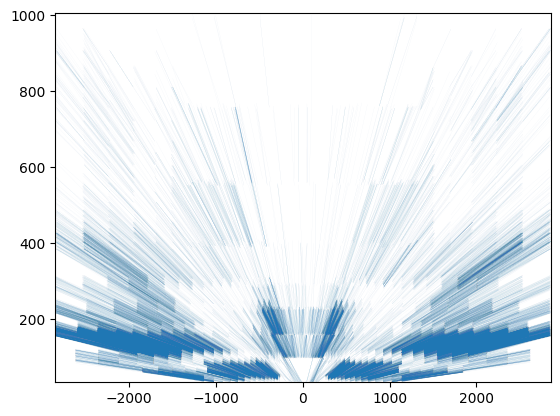

In [78]:
plt.figure()
draw_edges(graph_data, plt.gca(), graph_data.edge_index.numpy()[:, pruned_edge_mask], linewidths=0.1, alpha=0.1)

In [79]:
def edge_eta(data, edges):
    return 0.5*(data.hit_eta[edges[0]] + data.hit_eta[edges[1]])

Text(0.5, 0, 'eta')

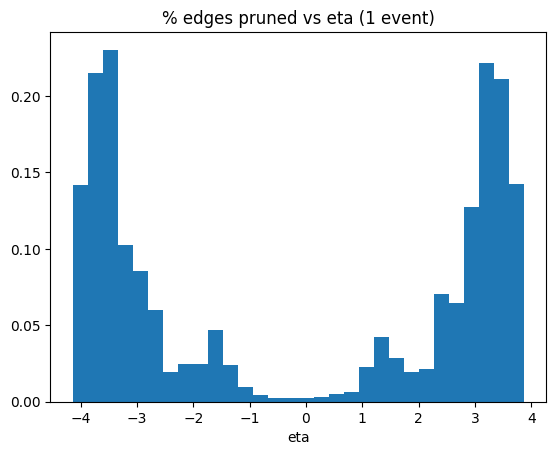

In [94]:
eta_bins_all_edges, bin_edges = np.histogram(edge_eta(graph_data, graph_data.edge_index).numpy(), range=(-4,4), bins=30)
eta_bins_pruned_edges, bin_edges = np.histogram(edge_eta(graph_data, graph_data.edge_index[:,pruned_edge_mask]).numpy(), range=(-4,4), bins=30)

vals = eta_bins_pruned_edges / eta_bins_all_edges
plt.bar(bin_edges[:-1], vals, width=np.diff(bin_edges))
plt.title("% edges pruned vs eta (1 event)")
plt.xlabel("eta")

In [14]:
sizesBeforePrune = []
sizesAfterPrune = []

for f in tqdm.tqdm(list(glob.glob("/datavol/training_data/testset/ttbar_uncorr_pu200_dumpv5_acorn2.0.0_module_map_minmax_event*.pyg"))[:100]):
    data = torch.load(f, map_location="cpu", weights_only=False)
    node_weights = [ 1 if r < 370 else 2 for r in data.hit_r ]
    newSrc, newDst = filterEdges(data.edge_index[0].numpy().tolist(),
                                 data.edge_index[1].numpy().tolist(),
                                 node_weights, 7)
    sizesAfterPrune.append(len(newSrc))
    sizesBeforePrune.append(data.edge_index.shape[1])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:12<00:00,  6.73s/it]


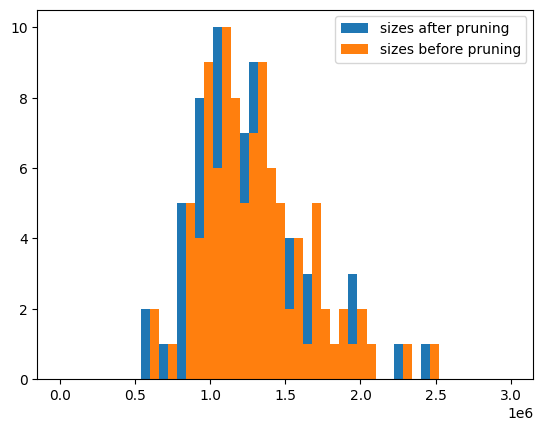

In [36]:
_, bins, _ = plt.hist(sizesAfterPrune, label="sizes after pruning", bins=50, range=(0,3e6))
_, bins, _ = plt.hist(sizesBeforePrune, label="sizes before pruning", bins=bins)
plt.legend()

Text(0.5, 1.0, 'size(before) - size(pruned)')

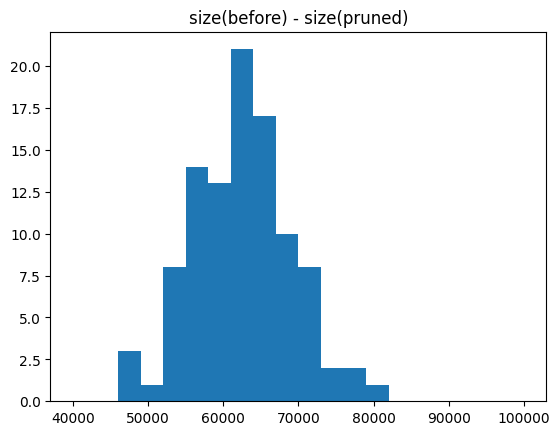

In [31]:
plt.hist(np.array(sizesBeforePrune) - np.array(sizesAfterPrune), bins=20, range=(40e3, 100e3))
plt.title("size(before) - size(pruned)")

Text(0.5, 1.0, 'size(pruned) / size(before)')

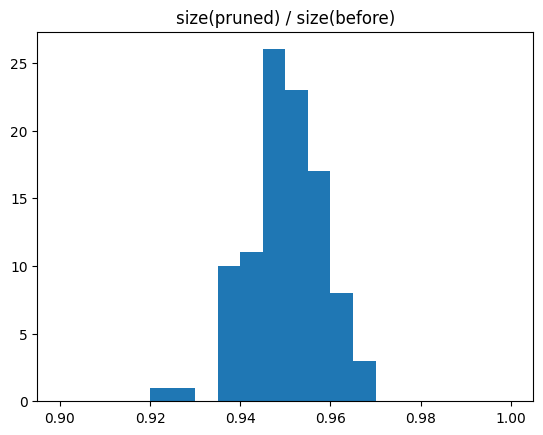

In [34]:
plt.hist(np.array(sizesAfterPrune) / np.array(sizesBeforePrune), bins=20, range=(0.9, 1))
plt.title("size(pruned) / size(before)")